<a href="https://colab.research.google.com/github/Avrutskiy/dneural/blob/master/nn_research_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
n_order = 10
np.random.seed(999)
#seed 1 error test = {no derivatives - 0.008, with derivatives - 0.0008 (first experiment), 0.0004 (second experiment)}, 
#seed 100 error test = {no derivatives - 0.006, with derivatives - 0.0007}
coefs = np.random.randn(n_order, n_order, 4)

def fs_function(coefs, x1, x2):
    f = np.zeros_like(x1)
    for i in range(coefs.shape[0]):
        for j in range(coefs.shape[1]):
            f += coefs[i, j, 0] * np.cos(i*x1) * np.cos(j*x2) / (i + 1) / (j + 1)
            f += coefs[i, j, 1] * np.cos(i*x1) * np.sin(j*x2) / (i + 1) / (j + 1)
            f += coefs[i, j, 2] * np.sin(i*x1) * np.cos(j*x2) / (i + 1) / (j + 1)
            f += coefs[i, j, 3] * np.sin(i*x1) * np.sin(j*x2) / (i + 1) / (j + 1)

    if f.shape == ():
        f = float(f)
    return f

def plot3d(X, Y, Z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)
    plt.show()

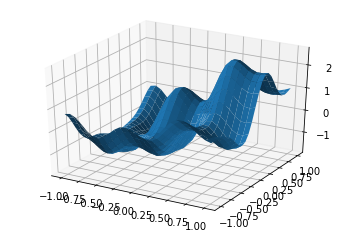

In [0]:
delta_train = 1/13-0.00001
X_train, Y_train = np.meshgrid(np.arange(-1, 1, delta_train), np.arange(-1, 1, delta_train))
Z_train = fs_function(coefs, X_train, Y_train)

mean_z_train = Z_train.mean()
std_z_train = Z_train.std()
Z_train = (Z_train - mean_z_train) / std_z_train

plot3d(X_train, Y_train, Z_train)

In [0]:
XY_train_flat = np.hstack([X_train.flatten()[:, None], Y_train.flatten()[:, None]])
Z_train_flat = Z_train.flatten()
print("Number train points:", len(Z_train_flat))

delta_test = 1/300-0.00001
X_test, Y_test = np.meshgrid(np.arange(-1, 1, delta_test), np.arange(-1, 1, delta_test))
XY_test_flat = np.hstack([X_test.flatten()[:, None], Y_test.flatten()[:, None]])

Z_test = (fs_function(coefs, X_test, Y_test) - mean_z_train) / std_z_train
Z_test_flat = Z_test.flatten()
print("Number test points:", len(Z_test_flat))

XY_train_tensor = torch.tensor(XY_train_flat, dtype=torch.float32).cuda()
Z_train_tensor = torch.tensor(Z_train_flat[:, None], dtype=torch.float32).cuda()
XY_test_tensor = torch.tensor(XY_test_flat, dtype=torch.float32).cuda()
Z_test_tensor = torch.tensor(Z_test_flat[:, None], dtype=torch.float32).cuda()

Number train points: 729
Number test points: 362404


In [0]:
#derivatives:
der_delta_mult = 0.00001
X_train_minus = X_train - delta_train * der_delta_mult
X_train_plus = X_train + delta_train * der_delta_mult
Y_train_minus = Y_train - delta_train * der_delta_mult
Y_train_plus = Y_train + delta_train * der_delta_mult

Z_train_x_minus = (fs_function(coefs, X_train_minus, Y_train) - mean_z_train) / std_z_train
Z_train_x_plus = (fs_function(coefs, X_train_plus, Y_train) - mean_z_train) / std_z_train

Z_train_y_minus = (fs_function(coefs, X_train, Y_train_minus) - mean_z_train) / std_z_train
Z_train_y_plus = (fs_function(coefs, X_train, Y_train_plus) - mean_z_train) / std_z_train

ZdX_train = (Z_train_x_plus - Z_train_x_minus)
ZdY_train = (Z_train_y_plus - Z_train_y_minus)

std_zdx_train = ZdX_train.std()
std_zdy_train = ZdY_train.std()

ZdX_train_flat = ZdX_train.flatten()
ZdY_train_flat = ZdY_train.flatten()

XminusY_train_flat = np.hstack([X_train_minus.flatten()[:, None], Y_train.flatten()[:, None]])
XplusY_train_flat = np.hstack([X_train_plus.flatten()[:, None], Y_train.flatten()[:, None]])
XYminus_train_flat = np.hstack([X_train.flatten()[:, None], Y_train_minus.flatten()[:, None]])
XYplus_train_flat = np.hstack([X_train.flatten()[:, None], Y_train_plus.flatten()[:, None]])

XminusY_train_tensor = torch.tensor(XminusY_train_flat, dtype=torch.float32).cuda()
XplusY_train_tensor = torch.tensor(XplusY_train_flat, dtype=torch.float32).cuda()
XYminus_train_tensor = torch.tensor(XYminus_train_flat, dtype=torch.float32).cuda()
XYplus_train_tensor = torch.tensor(XYplus_train_flat, dtype=torch.float32).cuda()

ZdX_train_tensor = torch.tensor(ZdX_train_flat[:, None], dtype=torch.float32).cuda()
ZdY_train_tensor = torch.tensor(ZdY_train_flat[:, None], dtype=torch.float32).cuda()

In [0]:
model = nn.Sequential()
model.add_module("dense0", nn.Linear(2, 128))
model.add_module("sigmoid0", nn.Sigmoid())
model.add_module("dense1", nn.Linear(128, 128))
model.add_module("sigmoid1", nn.Sigmoid())
model.add_module("dense2", nn.Linear(128, 128))
model.add_module("sigmoid2", nn.Sigmoid())
model.add_module("dense3", nn.Linear(128, 128))
model.add_module("sigmoid3", nn.Sigmoid())
model.add_module("dense4", nn.Linear(128, 128))
model.add_module("sigmoid4", nn.Sigmoid())
model.add_module("dense5", nn.Linear(128, 1))

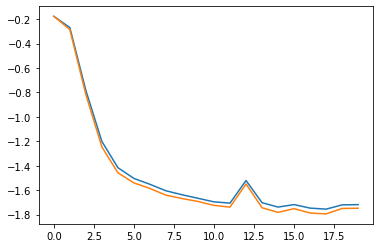

Iteration: 1000 	RMSE train: 0.01911969 	RMSE test: 0.017871486
Loss f (sqrt): 0.019114982 Loss fdx (sqrt): 0.07948799 Loss fdy (sqrt): 0.092553504


In [0]:
from IPython.display import clear_output

opt = torch.optim.Rprop(model.parameters(), lr=0.0002, step_sizes=(0, 50))

max_n_epochs = 1000
n_epochs_check = 50

loss_history = []
loss_history_test = []

derivative_weight = 1

for i in range(max_n_epochs):
    
    opt.zero_grad()
    
    model.train(True)
    
    Z_train_pred = model.cuda()(XY_train_tensor)
    ZdX_train_pred = model.cuda()(XplusY_train_tensor) - model.cuda()(XminusY_train_tensor)
    ZdY_train_pred = model.cuda()(XYplus_train_tensor) - model.cuda()(XYminus_train_tensor)
    
    loss_f = F.mse_loss(Z_train_pred, Z_train_tensor)
    loss_fdx = F.mse_loss(ZdX_train_pred, ZdX_train_tensor) / std_zdx_train**2
    loss_fdy = F.mse_loss(ZdY_train_pred, ZdY_train_tensor) / std_zdy_train**2
    
    loss = loss_f + derivative_weight*(loss_fdx + loss_fdy)
    
    loss.backward()
    opt.step()
    
    if (i + 1) % n_epochs_check == 0:
        clear_output(True)
        model.train(False)
        
        Z_train_pred = model.cuda()(XY_train_tensor)
        error = np.sqrt(F.mse_loss(Z_train_pred, Z_train_tensor).cpu().data.numpy())
        
        Z_test_pred = model.cuda()(XY_test_tensor)
        error_test = np.sqrt(F.mse_loss(Z_test_pred, Z_test_tensor).cpu().data.numpy())
        
        loss_history.append(np.log10(error))
        loss_history_test.append(np.log10(error_test))
        
        plt.plot(loss_history)
        plt.plot(loss_history_test)
        plt.show()
        
        print("Iteration:", i + 1, "\tRMSE train:", error, "\tRMSE test:", error_test)
        print("Loss f (sqrt):", np.sqrt(loss_f.cpu().data.numpy()), "Loss fdx (sqrt):", np.sqrt(loss_fdx.cpu().data.numpy()), "Loss fdy (sqrt):", np.sqrt(loss_fdy.cpu().data.numpy()))


(tensor(-0.1109, grad_fn=<MinBackward1>),
 tensor(0.1021, grad_fn=<MaxBackward1>),
 tensor(0.0178, grad_fn=<StdBackward0>))

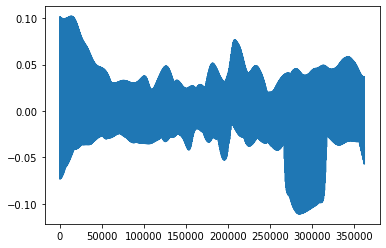

In [0]:
ans=model.cuda()(XY_test_tensor)-Z_test_tensor
plt.plot(ans.cpu().data.numpy())
ans.cpu().min(),ans.cpu().max(),ans.cpu().std()

(tensor(-0.1082, grad_fn=<MinBackward1>),
 tensor(0.1017, grad_fn=<MaxBackward1>),
 tensor(0.0191, grad_fn=<StdBackward0>))

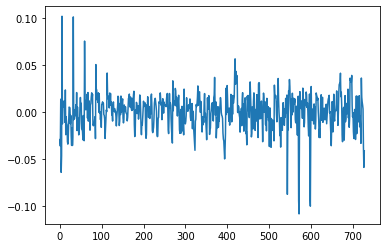

In [0]:
ans=model.cuda()(XY_train_tensor)-Z_train_tensor
plt.plot(ans.cpu().data.numpy())
ans.cpu().min(),ans.cpu().max(),ans.cpu().std()